# libraries

In [1]:
from nntool import unet
from utils.utilities import devtools
import os
import glob
import time
import joblib

import math
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from datetime import datetime


import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from glob import glob
from datetime import datetime
import subprocess
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.activations import softmax, sigmoid
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
from tensorflow.python.client import device_lib
from tensorflow.keras.models import load_model 

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from nntool import unet_h4

dtools = devtools()

In [2]:
from skimage import exposure
from skimage import img_as_float
from scipy import ndimage
from skimage.util import random_noise
import random
from pprint import pprint
# from dataflow import DataFlow

from custom_generator import KDataFlow
from custom_generator import KGenerator

import warnings
warnings.filterwarnings('ignore')

# input parameters

In [3]:
input_params = {
    
    # model training parameters 

    "depth" : 4,
    "batch_size" : 2,
    "epochs" : 20,
    "SEED" : np.random.randint(1000,7000),
    "IMG_HEIGHT" : 256, # <- 
    "IMG_WIDTH" : 256,
    "input_channels" : 1,
    
    "steps_per_epoch" : 64115 // 2,# (64115 //  batch_size) 
    "validation_steps" : 2693 // 2,# (2693 //  batch_size)
    
    # "steps_per_epoch" : 10,
    # "validation_steps" : 5,
    
    "learning_rate" : 1e-4,
    "use_multiprocessing" : True,
    "shuffle" : True,
    "patience":5,

    # verbose parameters
    "disp_gpu" : 'n',
    "TF_CPP_MIN_LOG_LEVEL":'0',

    # data generator parameters
    "rotation_range":60,
    "horizontal_flip":True,
    "vertical_flip":True,
    "fill_mode": "constant",
    "width_shift_range" : 0.2,
    "height_shift_range" : 0.2,
    "shear_range" : 0.3,
    "zoom_range" : 0.3,
    "rescale" :1./255,
    
    # standardization works on numpy data only we need to fit data look for this 
    "featurewise_center":False,
    "featurewise_std_normalization":False,
    "samplewise_center" : True,
    "samplewise_std_normalisation" : True,
    
    # save and load model weights/checkpoint ?
    "save_h5":'y',
    "save_ckpt":'n',
    
    
    "load_h5" : 'y',
    "load_ckpt": 'n'
}

# data loading 

In [4]:
train_df = joblib.load("./picklefiles/thold__req_img_mask_df_train")
val_df = joblib.load("./picklefiles/thold__req_img_mask_df_val")

failed_train_df = joblib.load("./picklefiles/thold__not_req_img_mask_df_train")
failed_val_df = joblib.load("./picklefiles/thold__not_req_img_mask_df_val")

In [5]:
failed_train_df.values[2]

array(['../data/coco-person/train/person_images/images/100081.jpg',
       '../data/coco-person/train/person_masks/masks/100081.jpg'],
      dtype=object)

In [6]:
#######################
## DEFINE GENERATORS ##
####################### 


kgen_train = KGenerator(train_df, failed_train_df, train_range=None, # none will lead to choose full dataset
                IMG_HEIGHT=256, IMG_WIDTH=256, as_gray=True,
                contrast_adjust=True, hist_equal=True,
                horizontal_flip=True, vertical_flip=True,
                random_rotation=True, random_zoom=True,
                gamma_correction=True, blur=True, add_noise=True,
                show_NOT_person_imgs=True,
                fit_op=True)

kgen_val = KGenerator(val_df, failed_val_df,
                IMG_HEIGHT=input_params['IMG_HEIGHT'], IMG_WIDTH=input_params['IMG_WIDTH'], as_gray=True,
                contrast_adjust=True, hist_equal=True,
                horizontal_flip=False, vertical_flip=False,
                random_rotation=False, random_zoom=False,
                gamma_correction=False, blur=True, add_noise=False,
                show_NOT_person_imgs=False,
                fit_op=True)


#########################
## DEFINE DATAFLOW OBJ ##
#########################
# kgen_train = joblib.load("./kgen_train_object")

# kgen_train.reqd_full_df = kgen_train.reqd_full_df[16000:]
# kgen_val.reqd_full_df = kgen_val.reqd_full_df[:20]

kd_train = KDataFlow(kgen_train,batch_size=2)
kd_val = KDataFlow(kgen_val,batch_size=2)

In [7]:
kgen_train.reqd_full_df.shape

(50630, 3)

In [8]:
kgen_val.reqd_full_df.shape

(2091, 3)

# Callbacks

In [9]:
depth = input_params['depth']
batch_size = input_params['batch_size']
epochs = input_params['epochs']


SEED = input_params['SEED']
IMG_HEIGHT = input_params['IMG_HEIGHT']
IMG_WIDTH = input_params['IMG_WIDTH']
input_image_channels = input_params['input_channels']


def exp_decay(epoch):
    if epoch < 5:
        return 1e-2
    return 0.001 * math.exp(0.01 * (5 - epoch))


logdir = "./logs/fit/" + datetime.now().strftime("%y%m%d-%H%M%S")
if input_params['save_h5']== 'y':
    ckptdir = "./logs/models/"+datetime.now().strftime("%y%m%d-%H%M%S")+"_" + \
            str(depth)+"U_ep{epoch:02d}-td-{dice_coef:.3f}-vd-{val_dice_coef:.3f}.h5"

elif input_params['save_ckpt'] == 'y':
    ckptdir = "./logs/models/"+datetime.now().strftime("%y%m%d-%H%M%S")+"_" + \
            str(depth)+"U_ep{epoch:02d}-td-{dice_coef:.3f}-vd-{val_dice_coef:.3f}.ckpt"

callbacks = [
        ReduceLROnPlateau(factor=0.01, patience=10, min_lr=1e-6, verbose=1),
        ModelCheckpoint(ckptdir, monitor='val_loss',
                        verbose=1, 
                        save_best_only=True, 
                        mode='min'),  # mode is max
        EarlyStopping(monitor='val_loss', mode='min', patience=8,
                       min_delta=0.0001, verbose=1),
        TensorBoard(log_dir=logdir),
        # LearningRateScheduler(exp_decay, verbose=1)
]

# model

In [10]:
model = unet_h4.model



print("#"*40)
print("\nCreated UNet ...\n")

lr = input_params['learning_rate'] 
# print("learning_rate = ", lr, "depth = ", input_params['depth'] ,"\n")

for i in (input_params.keys()):
    if i == "rotation_range":
        break
    
    print("{0:<20s} : ".format(i),"{0:<10}".format(str(input_params[i])))

print()
print("#"*40)
print()
# ans = input("Do you want to load trained model [y/n] ")

if input_params['load_h5'] == 'y':
    print("Choose Models dir ...\n")
    l = list(sorted(glob("./logs/models/*")))
    pprint(list(enumerate(sorted(glob("./logs/models/*")))))

    _ = int(input("Enter folder number -> "))

    p = l[_]
    l = sorted(glob(p+"/*"))
    pprint(list(enumerate(sorted(glob(p+"/*")))))
    _ = int(input("Enter file number -> "))
    req_p = l[_]
    print(req_p)

    model.load_weights(req_p, by_name=True)
    

# model.load_weights('./partial_trained.h5', by_name=True)
model.compile(optimizer=Adam(lr=lr,clipnorm=1.), loss=unet_h4.dice_loss, metrics=[unet_h4.dice_coef])
# model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.1), loss=unet.dice_coef_loss, metrics=[unet.dice_coef])
model.summary()

########################################

Created UNet ...

depth                :  4         
batch_size           :  2         
epochs               :  20        
SEED                 :  4155      
IMG_HEIGHT           :  256       
IMG_WIDTH            :  256       
input_channels       :  1         
steps_per_epoch      :  32057     
validation_steps     :  1346      
learning_rate        :  0.0001    
use_multiprocessing  :  True      
shuffle              :  True      
patience             :  5         
disp_gpu             :  n         
TF_CPP_MIN_LOG_LEVEL :  0         

########################################

Choose Models dir ...

[(0, './logs/models/10feb_1pass_complete'),
 (1, './logs/models/12feb_2pass_complete'),
 (2, './logs/models/13feb_3pass_complete'),
 (3, './logs/models/17feb_early_stop'),
 (4, './logs/models/8feb_58-58'),
 (5, './logs/models/9feb_58-58'),
 (6, './logs/models/best_10_ep'),
 (7, './logs/models/best_20_ep'),
 (8, './logs/models/best_34_eps_vd_69'),


# Fit generator

In [11]:
# In[17]:


# train_generator = g_train
# val_generator = g_val


# In[18]:
print("#"*40)
print("Begin Training UNet ...")
print("#"*40)


    
start = time.time()

history = model.fit_generator(
        generator=kd_train.getitem(),
        # steps_per_epoch=part//2, 
        steps_per_epoch=2500//2, 
        epochs=65,
        validation_data=kd_val.getitem(),
        # validation_steps=part//2, 
        validation_steps=2500//2,
        verbose=1,
        callbacks=callbacks,
        use_multiprocessing=input_params['use_multiprocessing'],
        # shuffle=input_params['shuffle'],
        # initial_epoch=1
)

end = time.time()

########################################
Begin Training UNet ...
########################################
Epoch 1/65
1249/1250 [============================>.] - ETA: 3s - loss: 0.2803 - dice_coef: 0.7197
End of Validation set shuffled and repeating...


Epoch 00001: val_loss improved from inf to 0.28355, saving model to ./logs/models/200312-001347_4U_ep01-td-0.720-vd-0.716.h5
1250/1250 [==============================] - 5371s 4s/step - loss: 0.2802 - dice_coef: 0.7198 - val_loss: 0.2836 - val_dice_coef: 0.7165
Epoch 2/65
1249/1250 [============================>.] - ETA: 3s - loss: 0.2772 - dice_coef: 0.7228
End of Validation set shuffled and repeating...


Epoch 00002: val_loss did not improve from 0.28355
1250/1250 [==============================] - 5251s 4s/step - loss: 0.2774 - dice_coef: 0.7226 - val_loss: 0.2837 - val_dice_coef: 0.7163
Epoch 3/65
1249/1250 [============================>.] - ETA: 3s - loss: 0.2756 - dice_coef: 0.7244
End of Validation set shuffled and repeating...

In [13]:
joblib.dump(kgen_train,"./kgen_train_object")

['./kgen_train_object']

In [12]:
model.save_weights("./partial_trained.h5")

In [ ]:
model.save("70_model_march9.h5")

In [ ]:
kgen_val.reqd_full_df.shape

# `lr 1e-4`
# `not using failed_df changed unet_h4`
----------

# note to self

- `currently using sigmoid`
- if growth stops or stays constant try using different **weight initializers**
- try going with trevsky loss function too
- weights of relu might start increasing a lot 
>- hence try using **l1 regularization after activation layers**
- see what happens in 1st 2 epochs

- **Do NOT use dropout after conv2d use batch normalization**(dropout is used for dense layers)
- TRY : **`Spatial Dropout`**


# do more data augmentations 

- [x] zoom operation
- [x] do multiple augmentations (blur & flips, zoom & blur, etc)
- [x] check if training steps are sufficient to cover all the dataset
- [x] show unet images that are not persons at all (use mask in order to remove person image) 
    - use failed images and remove persons
    - use current images and remove persons 
- [x] show random images which are not person and show blank masks
- [ ] random black boxes on images and train
- [x] add activity regularizers

Problems:

1. if you show more black images the model is not learning features of person, show images of person more.
2. reducing augmentations

# model tester

In [14]:
img_path_list = sorted(glob("../temp/images/*"))
msk_path_list = sorted(glob("../temp/masks/*"))


In [15]:
img_mask_list = [(i,j) for i,j in zip(img_path_list, msk_path_list)]

In [16]:
def histogram_equalization(img, msk, fit_op=True):
    img = exposure.equalize_hist(img)


    IMG,MSK =  img, msk
    if not fit_op:
        return IMG, MSK
    else:
        return IMG.reshape(IMG_HEIGHT, IMG_WIDTH, 1), MSK.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    

def get_test_image(img_path, mask_path, IMG_HEIGHT, IMG_WIDTH, fit_op=True, as_gray=True):
    img = io.imread(img_path, as_gray=as_gray)
    msk = io.imread(mask_path, as_gray=as_gray)

    img = resize(img, (IMG_HEIGHT, IMG_WIDTH))
    msk = resize(msk, (IMG_HEIGHT, IMG_WIDTH))
    
    
    msk = np.where(msk>0.5,1,0)
    
    img,msk = histogram_equalization(img,msk)
    
    
    IMG,MSK =  img, msk
    if not fit_op:
        return IMG, MSK
    else:
        return IMG.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1), MSK.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1)


def get_img_msk_path(img_mask_list):
    
    for i in img_mask_list:
        # print(i)
        yield i

gen_test = get_img_msk_path(img_mask_list)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

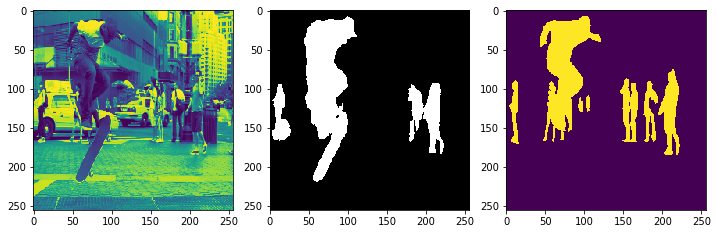

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

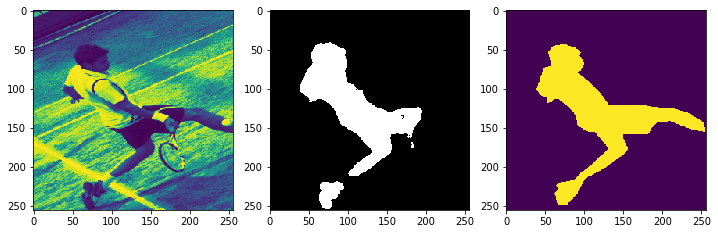

<Figure size 432x288 with 0 Axes>

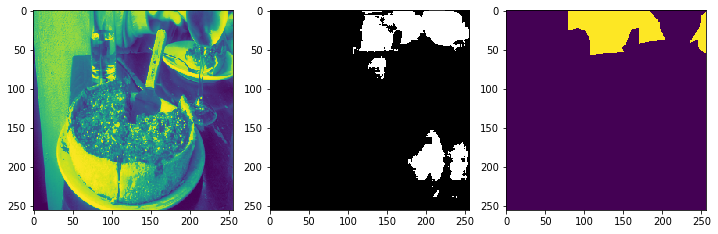

In [20]:
IMG_HEIGHT, IMG_WIDTH = 256,256

for j in range(10):
    # print(i)
    i = next(gen_test)
    img_path = i[0]
    msk_path = i[1]
    # img_true = io.imread(img_path)
    img, msk = get_test_image(img_path, msk_path, IMG_HEIGHT, IMG_WIDTH,  fit_op=True ,as_gray=True)



    pred_msk = model.predict([img])

    msk = np.uint32(msk)
    pred_msk = np.uint32(pred_msk)

    plt.figure()
    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
    ax1.imshow(np.squeeze(img))
    ax2.imshow(np.squeeze(pred_msk),cmap='gray')
    ax3.imshow(np.squeeze(msk))
    plt.tight_layout()
    plt.plot()

# Tf-lite